In [1]:
import os
import json
import numpy as np
import pandas as pd
from src import png

from src.data_loader import Shifted_Data_Loader
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from keras.models import model_from_json
    
from collections import Counter
import dit
from dit import Distribution
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import Isomap,TSNE

Using TensorFlow backend.


In [2]:
def load_config(run_dir,filename='config.json'):
    path = os.path.join(run_dir,filename)
    if os.path.exists(path):
        with open(path,'r') as config_json:
            conf = json.load(config_json)
        return conf

def load_model_spec(run_dir,filename='model.json'):
    path = os.path.join(run_dir,filename)

    if os.path.exists(path):
        with open(path,'r') as model_json:
            mod_spec = json.load(model_json)
            
        return mod_spec
    
def load_model(run_dir,mod_spec='model.json',weights='weights.h5'):
    spec_path = os.path.join(run_dir,mod_spec)
    weights_path = os.path.join(run_dir,weights)

    if os.path.exists(spec_path):
        with open(spec_path,'r') as model_json:
            mod_spec = json.load(model_json)
            
    mod = model_from_json(json.dumps(mod_spec))
    if os.path.exists(weights_path):
        mod.load_weights(weights_path)
    
    return mod

def get_l1_rf(mod,layer_name='dense_1',reverse=False):
    w = mod.get_layer(layer_name).get_weights()[0]
    rfs = [w[:,i].reshape(56,56) for i in np.arange(w.shape[-1])]
#     rfs_var = [rf.flatten().var() for rf in rfs]
    sorted_rfs = sorted(zip(rfs,np.arange(3000)),key=lambda rf: rf[0].flatten().var(),reverse=reverse)
#     sorted_rfs_var = [srf[1] for srf in sorted_rfs]
    sorted_rfs_units = [srf[1] for srf in sorted_rfs]
    sorted_rfs = [srf[0] for srf in sorted_rfs]
    
    return sorted_rfs,sorted_rfs_units

In [3]:
exp_root = '/home/elijahc/projects/vae/models/2019-05-24'
runs = []
for branches in os.listdir(exp_root):
    for leaf in os.listdir(os.path.join(exp_root,branches)):
        runs.append(os.path.join(exp_root,branches,leaf))

runs = list(filter(lambda x: 'ipynb_checkpoints' not in x,runs))
configs = [load_config(rd) for rd in runs]
model_specs = [load_model_spec(rd) for rd in runs]

In [4]:
def write_rfs(run_dir,start=500):
    mod = load_model(run_dir)
    print('run_dir: \n{}'.format(run_dir))
    print('Building Receptive Fields...')
    sorted_rfs,rfs_idx = get_l1_rf(mod)
    sorted_rfs_var = [rf.flatten().var() for rf in sorted_rfs]
    rf_flat = np.array(sorted_rfs[start:]).reshape(3000-start,56*56)

    rf_df = pd.DataFrame(rf_flat)
    rf_meta_df = pd.DataFrame({'var':sorted_rfs_var,'unit':rfs_idx})
    
    print('saving receptive fields and metadata...')
    rf_df.to_csv(os.path.join(run_dir,'l1_rfs.tsv'),sep='\t',index=False,header=False)
    rf_meta_df.to_csv(os.path.join(run_dir,'l1_rfs_meta.tsv'),sep='\t',index=False)
    return rf_df,rf_meta_df

In [5]:
rf_dfs = []
rf_metas = []
start = 0
for r in runs:
    rfs,rf_meta = write_rfs(r,start)
    rf_dfs.append(rfs)
    rf_metas.append(rf_meta)

run_dir: 
/home/elijahc/projects/vae/models/2019-05-24/xent_15_recon_0/label_corruption_0.0
Building Receptive Fields...
saving receptive fields and metadata...
run_dir: 
/home/elijahc/projects/vae/models/2019-05-24/xent_15_recon_25/label_corruption_0.0
Building Receptive Fields...
saving receptive fields and metadata...
run_dir: 
/home/elijahc/projects/vae/models/2019-05-24/xent_0_recon_25/label_corruption_0.0
Building Receptive Fields...
saving receptive fields and metadata...


In [6]:
for rf_meta,obj in zip(rf_metas,['Only Xent','Both','Only Recon']):
#     rf['objective'] = obj
    rf_meta['objective'] = obj

In [7]:
rf_metas[0].head()
# np.array(sorted_rfs).shape

,unit,var,objective
0,232,0.000326,Only Xent
1,1549,0.000326,Only Xent
2,1521,0.000327,Only Xent
3,2895,0.000327,Only Xent
4,1590,0.000328,Only Xent


In [8]:
rf_df_all = pd.concat(rf_dfs)
rf_meta_all = pd.concat(rf_metas)

In [9]:
rf_flat = rf_dfs[1].values
rf_flat.shape

(3000, 3136)

In [10]:
im_8bit_scaler = MinMaxScaler(feature_range=(0,255))
# rfs_8bit = im_8bit_scaler.fit_transform(rf_flat).reshape(3000,56,56)
# rfs_8bit = rfs_8bit.astype(np.uint8)

rfs_8bit = np.squeeze(np.array(
    [im_8bit_scaler.fit_transform(rf_flat[i].reshape(-1,1)).reshape(1,56,56).astype(np.uint8) for i in np.arange(3000-start)]
))
# np.save(os.path.join(run_dir,'rf_imgs','rfs'),rfs_8bit)

In [11]:
iso_mod = Isomap(n_components=2,n_jobs=5)
tsne_mod = TSNE(n_components=2)
iso_mod.fit(rf_flat)

Isomap(eigen_solver='auto', max_iter=None, n_components=2, n_jobs=5,
    n_neighbors=5, neighbors_algorithm='auto', path_method='auto', tol=0)

In [12]:
3000/60

50.0

In [14]:
nrows = 50
ncols = 60
rfs_8bit_mosaic = rfs_8bit.reshape(nrows,ncols,56,56)
tiles = rfs_8bit_mosaic
tiles = tiles.swapaxes(1, 2)
# tiles.shape
img = tiles.reshape(nrows*56,ncols*56)

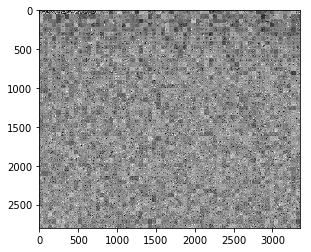

In [16]:
plt.imshow(img,cmap='gray')
# plt.i
# plt.imshow(img[:4*56,:4*56],cmap='gray')

In [ ]:
png.from_array(img,mode='L').save(os.path.join(runs[1],'rf_sprites.png'))

In [ ]:
plt.imshow(rfs_8bit[3])

In [ ]:
import scipy.signal as signal
out = signal.correlate2d(rfs_8bit[3],rfs_8bit[49],mode='same')
plt.imshow(out)

In [ ]:
out = signal.fftconvolve(rfs_8bit[3],rfs_8bit[70])
plt.imshow(out)

In [ ]:
idx = np.random.choice(np.arange(3000))
print(idx)
plt.imshow(rfs_8bit[idx],cmap='gray')

In [ ]:
# iso_out = iso_mod.transform(rf_flat)

In [ ]:
# plt.scatter(iso_out[:,0],iso_out[:,1])

In [ ]:
# plt.scatter(rf_tsne[:,0],rf_tsne[:,1])

In [ ]:
from tqdm import tqdm as tqdm
for i in tqdm(np.arange(2500)):
    png.from_array(rfs_8bit[i],mode='L').save(os.path.join(runs[1],'rf_imgs','rf_{}.png'.format(i)))

In [ ]:
plt.hist(rfs_var)

In [ ]:
sns.kdeplot(rfs_var)

In [ ]:
np.where(np.array(sorted_rfs_var)>0.04)[0]